[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/alvaro-francisco-gil/nn4nlp/blob/main/exercises/practica1_francisco_gil_alvaro.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import itertools
import re
import string
from collections import Counter
from typing import List, Tuple

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy.sparse as sp
import tensorflow as tf
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Analyze Data

In [ ]:
train_file = '/content/drive/MyDrive/master/neural_nets_4_nlp/tema1/data/train_reviews.csv'
df = pd.read_csv(train_file)
df.head()

,id,review,sentiment
0,17527,People tried to make me believe that the premi...,negative
1,24155,I have been wanting to see cut since the day i...,positive
2,21972,This movie is terrible. The suspense is spent ...,negative
3,4565,I hope she can keep acting and directing. She'...,positive
4,22098,I fell in love with this silent action drama. ...,positive


In [ ]:
df.shape

(8000, 3)

In [ ]:
test_file = '/content/drive/MyDrive/master/neural_nets_4_nlp/tema1/data/test_reviews.csv'
test_df = pd.read_csv(test_file)
test_df.head()

,id,review,sentiment
0,6666,Movies about dinosaurs can be entertaining. So...,negative
1,23267,If it's action and adventure you want in a mov...,positive
2,2897,Barbra Streisand is a tour de force in this Ho...,positive
3,23177,I borrowed this movie despite its extremely lo...,positive
4,14171,"""Baby Face"" is a precode melodrama starring a ...",positive


In [ ]:
test_df.shape

(2000, 3)

## Check class balance

In [ ]:
df.value_counts('sentiment')

,count
sentiment,
positive,4012
negative,3988


In [ ]:
test_df.value_counts('sentiment')

,count
sentiment,
negative,1025
positive,975


Both classes are balanced

## Check missing values

In [ ]:
df.isna().sum()


,0
id,0
review,0
sentiment,0


In [ ]:
test_df.isna().sum()

,0
id,0
review,0
sentiment,0


## Visual Inspection

In [ ]:
df.iloc[1]['review']

"I have been wanting to see cut since the day i have heard of it, which was sometime last year. Anyway i got to see today, and when the movie started i thought that it started rather week but it got better after 10 mins or so. I thought that the movie was pretty good. but the thing i didn't like was how the killer was created, i was thinking just before i rented that it would probably suck just like Urban legends: final cut, i almost died it. mostly everything in UL final cut needed to be improved. CUT is 100 times better than UL:final cut. The best part of CUT is the killer and the death scenes. The killer kicks MO F***ING ASS.<br /><br />i give cut a 8 out of 10"

In [ ]:
df.iloc[2]['review']

'This movie is terrible. The suspense is spent waiting for a point. There isn\'t much of one.<br /><br />Aside from a few great lines ( "I found a tooth in my apartment" ), and the main characters dedication to killing himself, it\'s a collection of supposedly eerie sounds.<br /><br />'

Insigths:
- Needd to remove HTML labels
- Not in lowercase

## Word Histogram

In [ ]:
def plot_word_histogram(text_array):
    # Convert input to a flat list of strings
    if isinstance(text_array, str):
        # If it's a single string, convert to list
        text_array = [text_array]
    elif isinstance(text_array, list):
        # Flatten nested lists and ensure all elements are strings
        flattened = []
        for item in text_array:
            if isinstance(item, list):
                flattened.extend(item)
            else:
                flattened.append(item)
        text_array = [str(item) for item in flattened]
    else:
        raise ValueError("Input must be a string or a list of strings.")

    # Join all text into one string
    all_text = ' '.join(text_array)

    # Tokenize words by splitting on whitespace
    words = all_text.split()

    # Count word frequencies
    word_counts = Counter(words)
    labels, values = zip(*word_counts.items())

    # Sort by frequency in descending order
    sorted_indices = np.argsort(values)[::-1]
    labels = np.array(labels)[sorted_indices]
    values = np.array(values)[sorted_indices]

    # Plot the histogram for the top 10 most frequent words
    plt.figure(figsize=(10, 6))
    plt.bar(labels[:10], values[:10], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

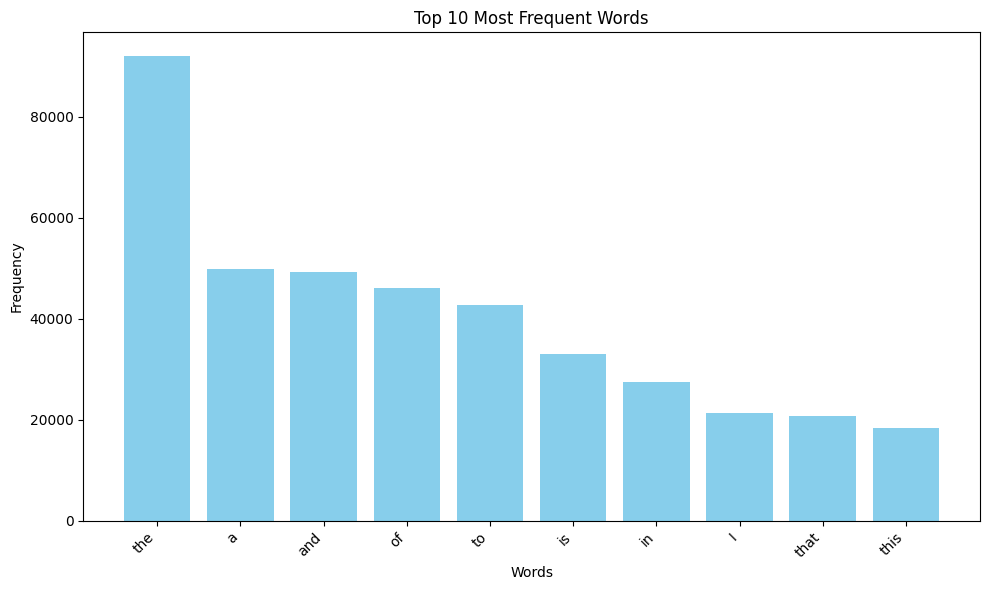

In [ ]:
plot_word_histogram(df['review'].to_list())

# Pre-processing

In [ ]:
data = np.concatenate([df['review'].values,test_df['review'].values],axis=0)
data.shape

(10000,)

## Remove HTML labels

In [ ]:
def clean_htmls_text_array(text_array):

    def remove_html_tags(text):
        pattern = re.compile('<.*?>')
        clean_text = re.sub(pattern, '', text)
        clean_text = ' '.join(clean_text.split())
        return clean_text

    cleaned_array = [remove_html_tags(text) for text in text_array]

    return cleaned_array

In [ ]:
data[1][-40:]

'ASS.<br /><br />i give cut a 8 out of 10'

In [ ]:
data = clean_htmls_text_array(data)

In [ ]:
data[1][-40:]

' MO F***ING ASS.i give cut a 8 out of 10'

## Downcase

In [ ]:
def lowercase_array(text_array):
    return [text.lower() for text in text_array]

In [ ]:
data = lowercase_array(data)

In [ ]:
data[1][-40:]

' mo f***ing ass.i give cut a 8 out of 10'

I don't want to remove the numbers as they may contain valuable information for the classifier, as in this case: "8 out of 10"

I test the hypothesis:

In [ ]:
def find_term_with_context(text_array, term, context_chars=5):
    occurrences = 0
    occurrences_list = []

    for text in text_array:
        start = 0
        while (start := text.find(term, start)) != -1:
            occurrences += 1
            context_start = max(0, start - context_chars)
            context_end = min(len(text), start + len(term) + context_chars)
            context = text[context_start:context_end]

            occurrences_list.append(f"...{context}...")
            start += len(term)

    print(f"\nTotal occurrences of '{term}': {occurrences}")
    return occurrences, occurrences_list

In [ ]:
_,ocurrences = find_term_with_context(data, 'out of')
ocurrences[1]


Total occurrences of 'out of': 2070


'... a 3 out of 10, ...'

We see that 2070 reviews contain a possible explicit grade

## Expand Contractions

In [ ]:
def expand_contractions(texts):
    contractions = {
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }
    def expand(text):
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        return text
    return [expand(text) for text in texts]

In [ ]:
data[0][330:380]

"a never-ending murder spree. it's not a highly ori"

In [ ]:
data = expand_contractions(data)

In [ ]:
data[0][330:380]

'a never-ending murder spree. it is not a highly or'

## Remove Punctuation

In [ ]:
def remove_punctuation(texts):
    translator = str.maketrans('', '', string.punctuation)
    return [text.translate(translator) for text in texts]

In [ ]:
data = remove_punctuation(data)

In [ ]:
data[0][330:380]

'erending murder spree it is not a highly original '

## Tokenization

In [ ]:
def tokenize_texts(texts):
    return [word_tokenize(text) for text in texts]

In [ ]:
data = tokenize_texts(data)

In [ ]:
data[0][:5]

['people', 'tried', 'to', 'make', 'me']

## Lemmatization

In [ ]:
def lemmatize_texts(tokenized_texts):
    lemmatizer = WordNetLemmatizer()
    return [[lemmatizer.lemmatize(word) for word in text] for text in tokenized_texts]

In [ ]:
data[0][29]

'escapes'

In [ ]:
data = lemmatize_texts(data)

In [ ]:
data[0][29]

'escape'

## Stopword Removal

In [ ]:
def remove_stopwords(tokenized_texts):
    stop_words = set(stopwords.words('english'))
    return [[word for word in text if word.lower() not in stop_words] for text in tokenized_texts]

In [ ]:
data[0][:7]

['people', 'tried', 'to', 'make', 'me', 'believe', 'that']

In [ ]:
data = remove_stopwords(data)

In [ ]:
data[0][:7]

['people', 'tried', 'make', 'believe', 'premise', 'rubbishy', 'supernatural']

## Processed Word Histogram

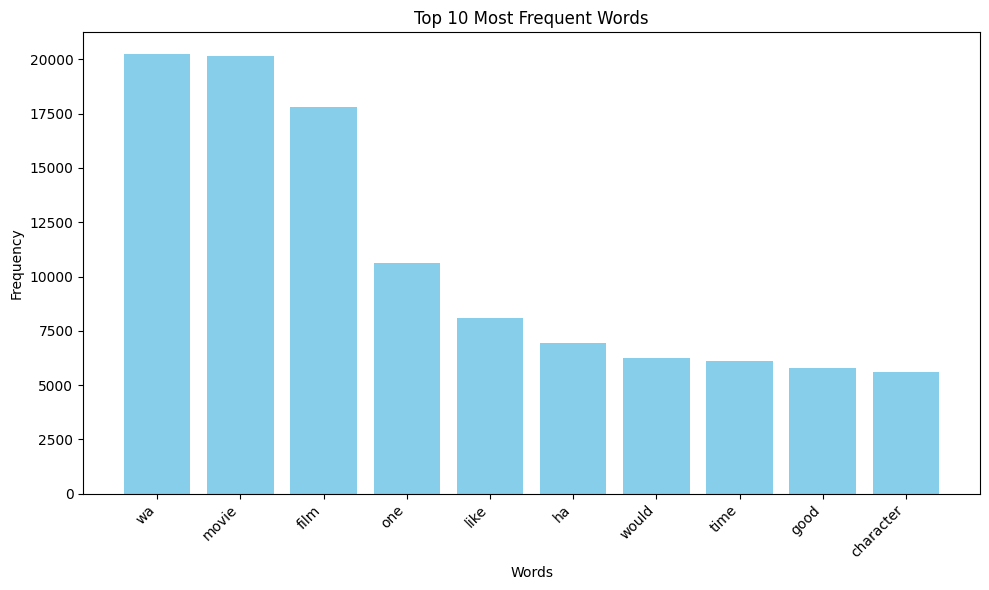

In [ ]:
plot_word_histogram(data)

# Encoding

In [ ]:
combined_sentiments = np.concatenate([df['sentiment'].values, test_df['sentiment'].values])
combined_sentiments.shape

(10000,)

## Bag of Words

In [ ]:
def encode_bow(data: List[List[str]], labels: List[str], train_size: int = 8000) -> Tuple:
    # Convert list of word lists to list of sentences
    data = [' '.join(doc) for doc in data]

    # Encode the sentiment labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Split the data
    X_train = data[:train_size]
    X_test = data[train_size:]
    y_train = y_encoded[:train_size]
    y_test = y_encoded[train_size:]

    # Apply CountVectorizer (BoW)
    count_vect = CountVectorizer(analyzer='word', min_df=1)
    X_train_encoded = count_vect.fit_transform(X_train)
    X_test_encoded = count_vect.transform(X_test)

    return (X_train_encoded, X_test_encoded, y_train, y_test)

In [ ]:
# For Bag of Words
X_train_bow, X_test_bow, y_train_bow, y_test_bow = encode_bow(data, combined_sentiments)

In [ ]:
print("Bag of Words (BoW) Shapes:")
print(f"X_train_bow shape: {X_train_bow.shape}")
print(f"X_test_bow shape: {X_test_bow.shape}")
print(f"y_train_bow shape: {y_train_bow.shape}")
print(f"y_test_bow shape: {y_test_bow.shape}")

Bag of Words (BoW) Shapes:
X_train_bow shape: (8000, 65340)
X_test_bow shape: (2000, 65340)
y_train_bow shape: (8000,)
y_test_bow shape: (2000,)


## TF-IDF weighted scheme

In [ ]:
def encode_tfidf(data: List[List[str]], labels: List[str], train_size: int = 8000) -> Tuple:
    # Convert list of word lists to list of sentences
    data = [' '.join(doc) for doc in data]

    # Encode the sentiment labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Split the data
    X_train = data[:train_size]
    X_test = data[train_size:]
    y_train = y_encoded[:train_size]
    y_test = y_encoded[train_size:]

    # Apply TF-IDF
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=1)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    return (X_train_tfidf, X_test_tfidf, y_train, y_test)

In [ ]:
# For TF-IDF weighted scheme
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = encode_tfidf(data, combined_sentiments)

In [ ]:
print("TF-IDF Shapes:")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"y_train_tfidf shape: {y_train_tfidf.shape}")
print(f"y_test_tfidf shape: {y_test_tfidf.shape}")

TF-IDF Shapes:
X_train_tfidf shape: (8000, 65340)
X_test_tfidf shape: (2000, 65340)
y_train_tfidf shape: (8000,)
y_test_tfidf shape: (2000,)


## Word2vec

In [ ]:
def encode_word2vec(data: List[List[str]], labels: List[str], train_size: int = 8000) -> Tuple:
    # Encode the sentiment labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Split the data
    X_train = data[:train_size]
    X_test = data[train_size:]
    y_train = y_encoded[:train_size]
    y_test = y_encoded[train_size:]

    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=data, vector_size=100, window=5, min_count=1, workers=4)

    # Create document embeddings by averaging word vectors
    def document_vector(doc):
        word_vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

    X_train_w2v = np.array([document_vector(doc) for doc in X_train])
    X_test_w2v = np.array([document_vector(doc) for doc in X_test])

    return (X_train_w2v, X_test_w2v, y_train, y_test)

In [ ]:
# For Word Embeddings (Word2Vec)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = encode_word2vec(data, combined_sentiments)

In [ ]:
print("Word2Vec Shapes:")
print(f"X_train_w2v shape: {X_train_w2v.shape}")
print(f"X_test_w2v shape: {X_test_w2v.shape}")
print(f"y_train_w2v shape: {y_train_w2v.shape}")
print(f"y_test_w2v shape: {y_test_w2v.shape}")

Word2Vec Shapes:
X_train_w2v shape: (8000, 100)
X_test_w2v shape: (2000, 100)
y_train_w2v shape: (8000,)
y_test_w2v shape: (2000,)


# Machine Learning

In [ ]:
# Plot Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on")
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

# Train and Evaluate Classifier
def train_and_evaluate_classifier(X, y, estimator, grid):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, param_grid=grid,
                              cv=cv, error_score=0.0,
                              n_jobs=-1, verbose=5)

    print("Training model...")
    classifier.fit(X, y)

    # Print cross-validation scores for each configuration
    print("CV-scores for each grid configuration:")
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in sorted(zip(means, stds,
                                         classifier.cv_results_['params']),
                                     key=lambda x: -x[0]):
        print(f"Accuracy: {mean:.3f} (+/-{std * 2:.3f}) for params: {params}")

    # Plot learning curve for the best estimator
    print("Learning curve for the best estimator:")
    plot_learning_curve(classifier.best_estimator_,
                        f"Learning Curve ({estimator.__class__.__name__})",
                        X, y)

    return classifier

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Test Classification Models
def test_classification_models(X_train, y_train, X_test, y_test, models_to_use=None):
    all_models = {
        'Naive Bayes': (MultinomialNB(), {}),
        'Logistic Regression': (LogisticRegression(max_iter=1000, solver='saga'), {'C': [0.1, 1.0, 10]}),
        'SVM': (SVC(), {'C': [0.1, 1.0], 'kernel': ['linear', 'rbf']}),
        'Random Forest': (RandomForestClassifier(), {'n_estimators': [50], 'max_depth': [None]})
    }

    if models_to_use is None:
        models = all_models
    else:
        models = {name: all_models[name] for name in models_to_use if name in all_models}

    best_accuracy = 0

    for name, (estimator, grid) in models.items():
        print(f"Testing model: {name}")

        # Train and evaluate the model without retaining the classifier
        classifier = train_and_evaluate_classifier(X_train, y_train, estimator, grid)

        # Test accuracy on the test set
        accuracy = classifier.score(X_test, y_test)
        print(f"Test Accuracy for {name}: {accuracy:.4f}\n")

        if accuracy > best_accuracy:
            best_accuracy = accuracy

            # Confusion Matrix for the Best Model
            predictions = classifier.predict(X_test)
            cm = confusion_matrix(y_test, predictions)
            plot_confusion_matrix(cm, classes=np.unique(y_train), title=f"Confusion Matrix ({name})")

            print(f"Best Model Updated: {name} with Accuracy: {accuracy:.4f}")

    print(f"Best Accuracy across all models: {best_accuracy:.4f}")

Testing model: Naive Bayes
Training model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV-scores for each grid configuration:
Accuracy: 0.855 (+/-0.017) for params: {}
Learning curve for the best estimator:


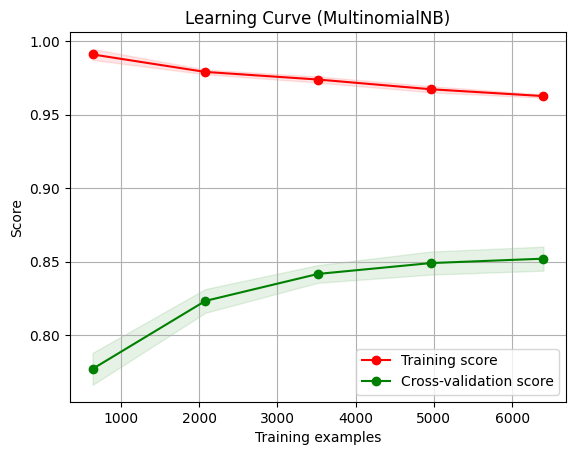

Test Accuracy for Naive Bayes: 0.8450

Confusion matrix without normalization


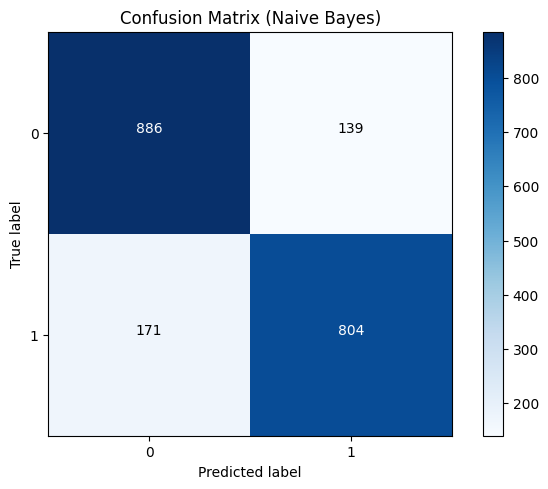

Best Model Updated: Naive Bayes with Accuracy: 0.8450
Testing model: Logistic Regression
Training model...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
CV-scores for each grid configuration:
Accuracy: 0.858 (+/-0.014) for params: {'C': 0.1}
Accuracy: 0.853 (+/-0.017) for params: {'C': 1.0}
Accuracy: 0.853 (+/-0.019) for params: {'C': 10}
Learning curve for the best estimator:


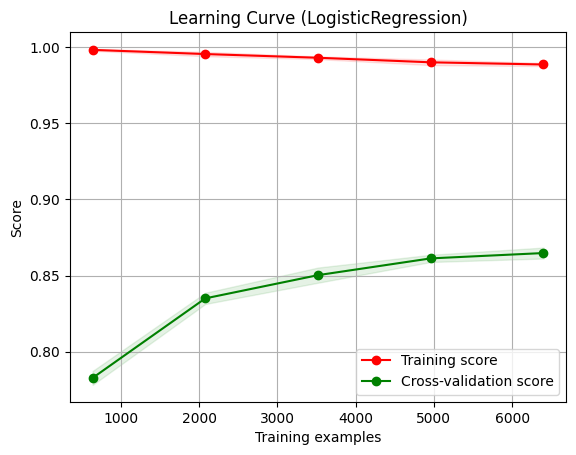

Test Accuracy for Logistic Regression: 0.8610

Confusion matrix without normalization


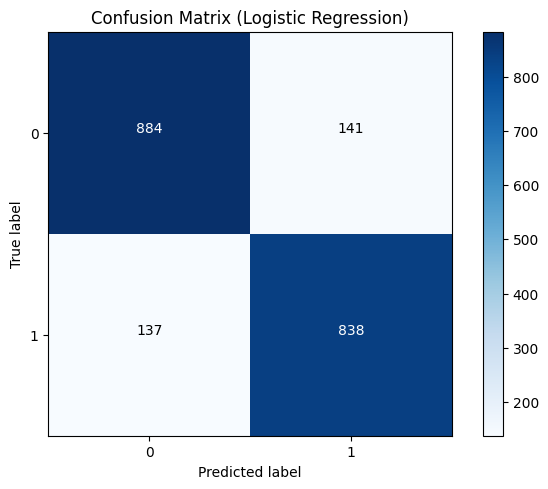

Best Model Updated: Logistic Regression with Accuracy: 0.8610
Testing model: SVM
Training model...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
CV-scores for each grid configuration:
Accuracy: 0.840 (+/-0.020) for params: {'C': 1.0, 'kernel': 'rbf'}
Accuracy: 0.838 (+/-0.020) for params: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.832 (+/-0.021) for params: {'C': 1.0, 'kernel': 'linear'}
Accuracy: 0.711 (+/-0.034) for params: {'C': 0.1, 'kernel': 'rbf'}
Learning curve for the best estimator:


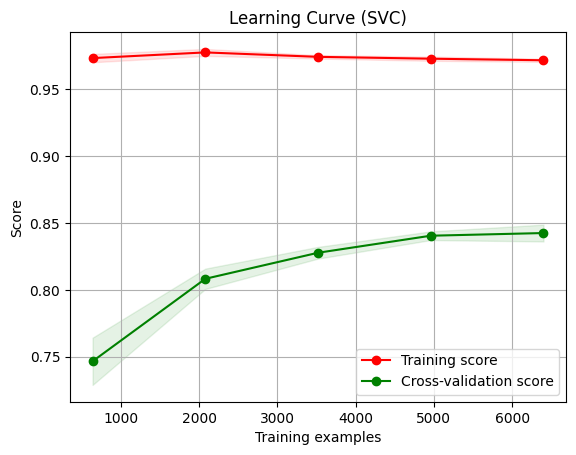

Test Accuracy for SVM: 0.8435

Testing model: Random Forest
Training model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV-scores for each grid configuration:
Accuracy: 0.817 (+/-0.016) for params: {'max_depth': None, 'n_estimators': 50}
Learning curve for the best estimator:


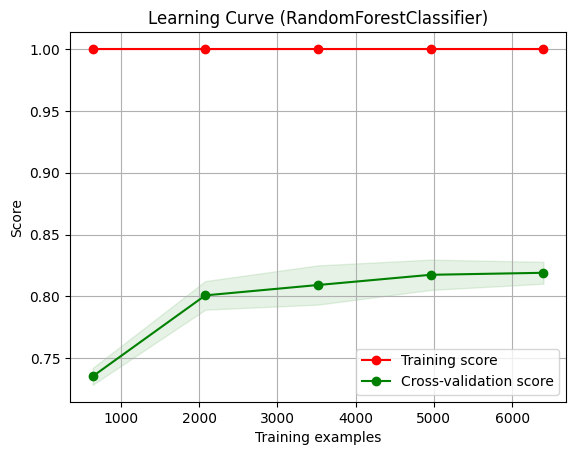

Test Accuracy for Random Forest: 0.8275

Best Accuracy across all models: 0.8610


In [ ]:
best_model_bow = test_classification_models(X_train=X_train_bow,
                                            y_train=y_train_bow,
                                            X_test=X_test_bow,
                                            y_test=y_test_bow)

Testing model: Naive Bayes
Training model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV-scores for each grid configuration:
Accuracy: 0.856 (+/-0.015) for params: {}
Learning curve for the best estimator:


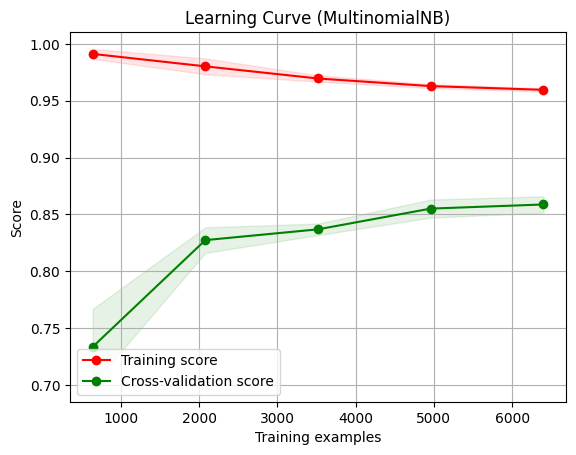

Test Accuracy for Naive Bayes: 0.8540

Confusion matrix without normalization


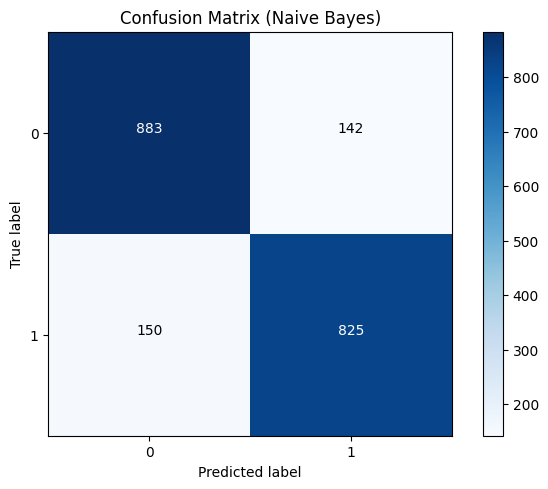

Best Model Updated: Naive Bayes with Accuracy: 0.8540
Testing model: Logistic Regression
Training model...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
CV-scores for each grid configuration:
Accuracy: 0.864 (+/-0.012) for params: {'C': 10}
Accuracy: 0.861 (+/-0.014) for params: {'C': 1.0}
Accuracy: 0.829 (+/-0.028) for params: {'C': 0.1}
Learning curve for the best estimator:


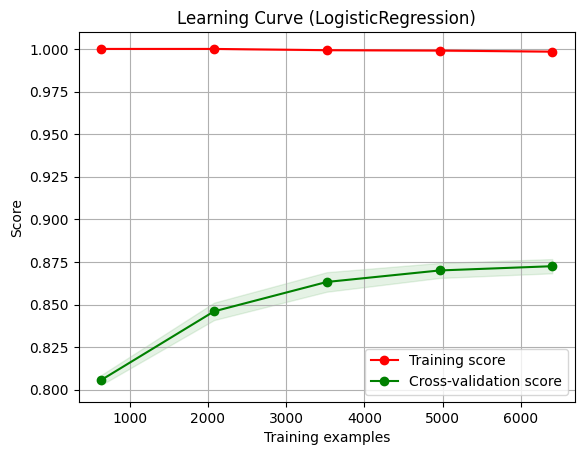

Test Accuracy for Logistic Regression: 0.8715

Confusion matrix without normalization


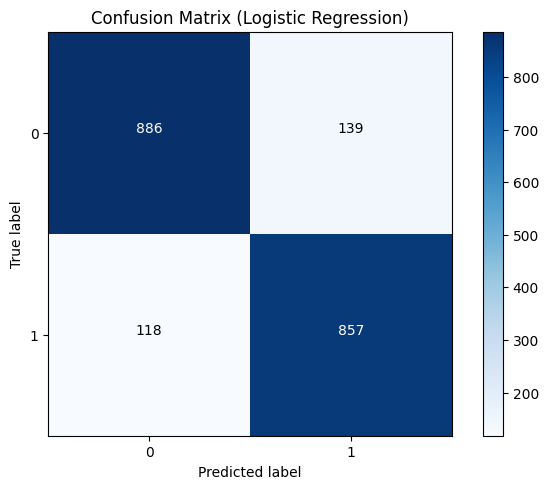

Best Model Updated: Logistic Regression with Accuracy: 0.8715
Testing model: SVM
Training model...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
CV-scores for each grid configuration:
Accuracy: 0.863 (+/-0.014) for params: {'C': 1.0, 'kernel': 'rbf'}
Accuracy: 0.862 (+/-0.015) for params: {'C': 1.0, 'kernel': 'linear'}
Accuracy: 0.809 (+/-0.030) for params: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.589 (+/-0.086) for params: {'C': 0.1, 'kernel': 'rbf'}
Learning curve for the best estimator:


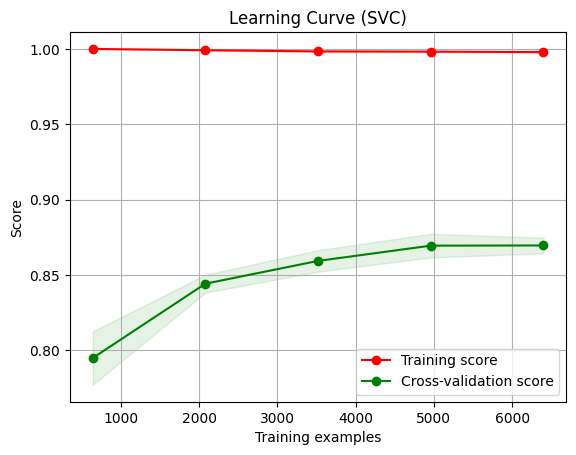

Test Accuracy for SVM: 0.8650

Testing model: Random Forest
Training model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV-scores for each grid configuration:
Accuracy: 0.819 (+/-0.025) for params: {'max_depth': None, 'n_estimators': 50}
Learning curve for the best estimator:


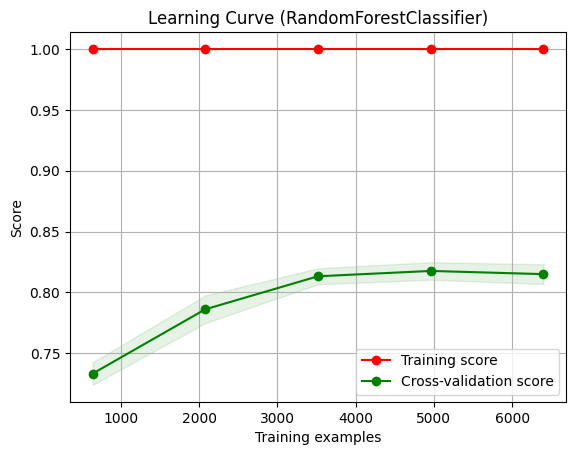

Test Accuracy for Random Forest: 0.8105

Best Accuracy across all models: 0.8715


In [ ]:
best_model_tfidf = test_classification_models(X_train=X_train_tfidf,
                                              y_train=y_train_tfidf,
                                              X_test=X_test_tfidf,
                                              y_test=y_test_tfidf)

Testing model: Logistic Regression
Training model...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
CV-scores for each grid configuration:
Accuracy: 0.795 (+/-0.025) for params: {'C': 10}
Accuracy: 0.791 (+/-0.023) for params: {'C': 1.0}
Accuracy: 0.778 (+/-0.025) for params: {'C': 0.1}
Learning curve for the best estimator:


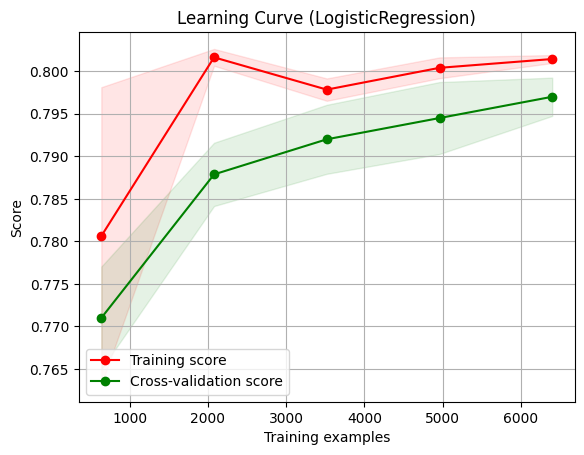

Test Accuracy for Logistic Regression: 0.8050

Confusion matrix, without normalization


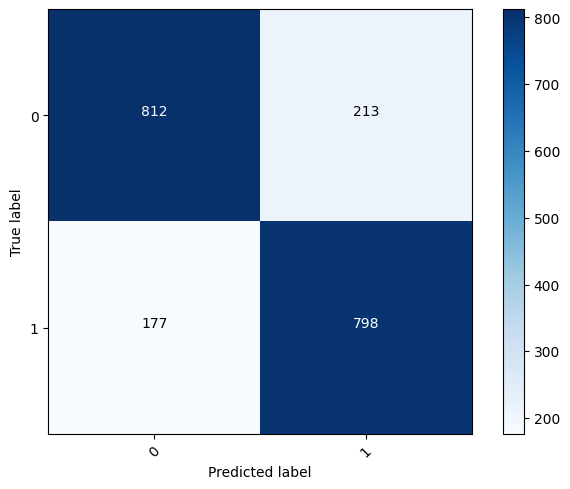

Best Model Updated: Logistic Regression with Accuracy: 0.8050
Testing model: SVM
Training model...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
CV-scores for each grid configuration:
Accuracy: 0.792 (+/-0.025) for params: {'C': 1.0, 'kernel': 'linear'}
Accuracy: 0.785 (+/-0.021) for params: {'C': 1.0, 'kernel': 'rbf'}
Accuracy: 0.784 (+/-0.023) for params: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.754 (+/-0.024) for params: {'C': 0.1, 'kernel': 'rbf'}
Learning curve for the best estimator:


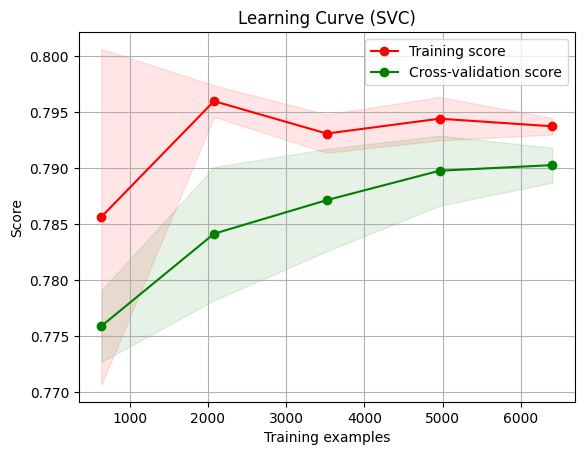

Test Accuracy for SVM: 0.7905

Testing model: Random Forest
Training model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV-scores for each grid configuration:
Accuracy: 0.762 (+/-0.023) for params: {'max_depth': None, 'n_estimators': 50}
Learning curve for the best estimator:


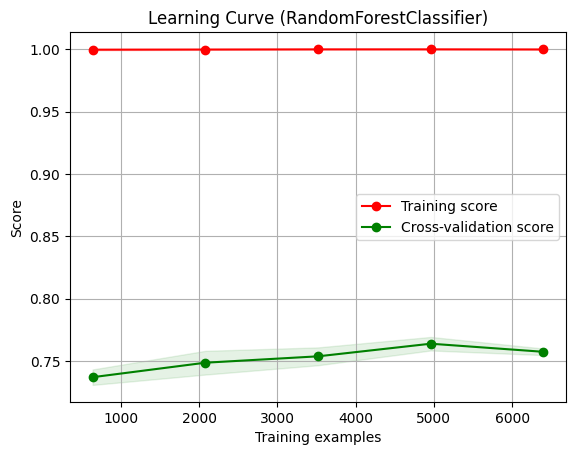

Test Accuracy for Random Forest: 0.7520

Best Accuracy across all models: 0.8050


In [ ]:
best_model_w2v = test_classification_models(X_train=X_train_w2v,
                                            y_train=y_train_w2v,
                                            X_test=X_test_w2v,
                                            y_test=y_test_w2v,
                                            models_to_use=['Logistic Regression', 'SVM', 'Random Forest'])

All of the results are aroung 80-95% of accuracy. The best result for this dataset is "TF-IDF" and "Logistic Regression" with Accuracy: 0.8715

# Deep Learning

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
def test_neural_networks(X_train, y_train, X_test, y_test, encoding_type):
    if sp.issparse(X_train):
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    architectures = [
        ('Simple NN', [32]),
        ('Medium NN', [64, 32]),
        ('Deep NN', [64, 32, 16])
    ]

    learning_rate = 0.001
    best_accuracy = 0

    for name, layers in architectures:
        print(f"Testing {name}")

        model = Sequential([
            Input(shape=(X_train.shape[1],))
        ])
        for units in layers:
            model.add(Dense(units, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=0)

        # Evaluate the model
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy

            # Plot learning curve
            plt.figure(figsize=(10, 6))
            plt.plot(history.history['accuracy'], label='Training Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title(f'Learning Curve - {encoding_type} - {name}')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

            # Plot confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                                  title=f'Confusion Matrix - {encoding_type} - {name}')

            # Print classification report
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

    print(f"Best Accuracy for {encoding_type}: {best_accuracy:.4f}")

The dimensions of the 'BOW' aND 'TF-IDF' data are too large por a neural network given my actual RAM

In [ ]:
# test_neural_networks(X_train_bow, y_train_bow, X_test_bow, y_test_bow, "BOW")

In [ ]:
# test_neural_networks(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, "TF-IDF")

Testing Simple NN
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.7860


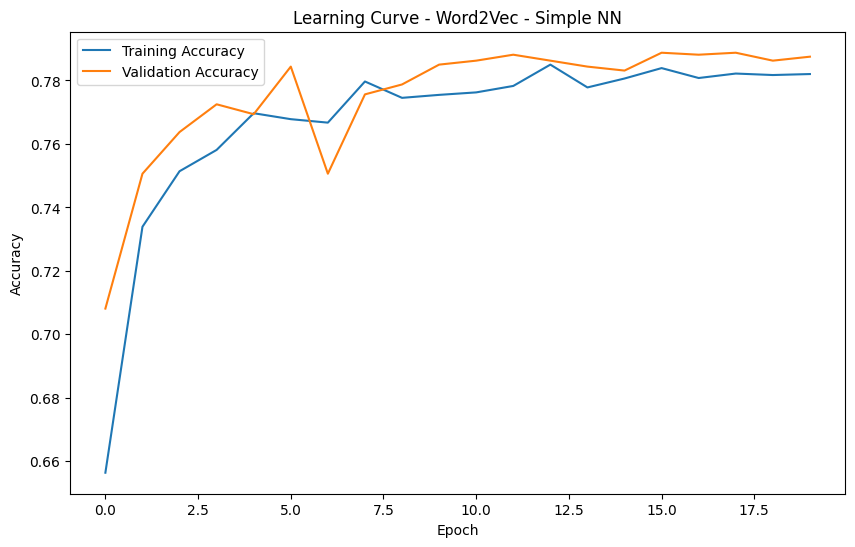

Confusion matrix, without normalization


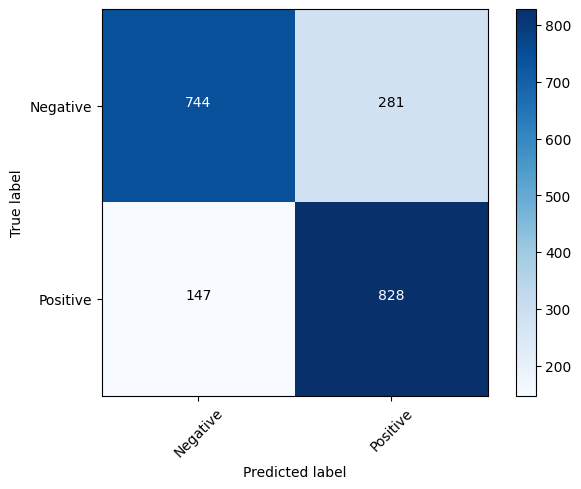


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1025
           1       0.75      0.85      0.79       975

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000

Testing Medium NN
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.7540
Testing Deep NN
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.7900


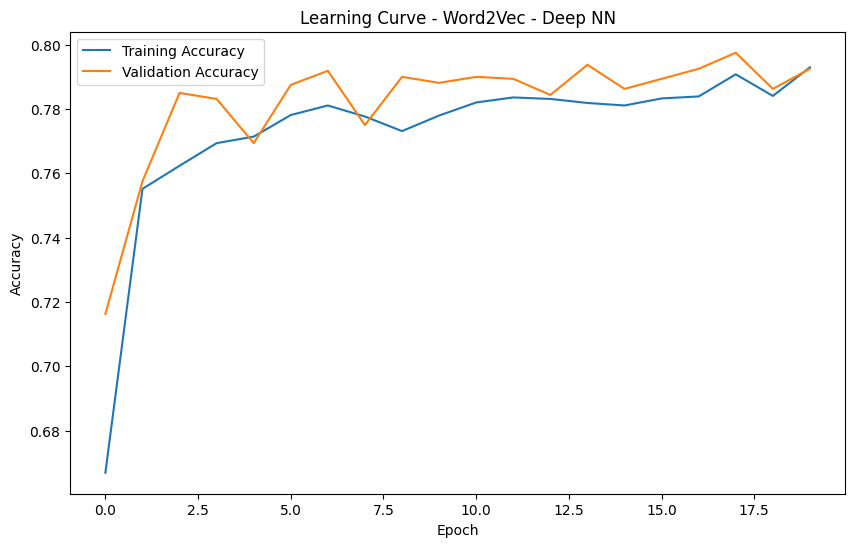

Confusion matrix, without normalization


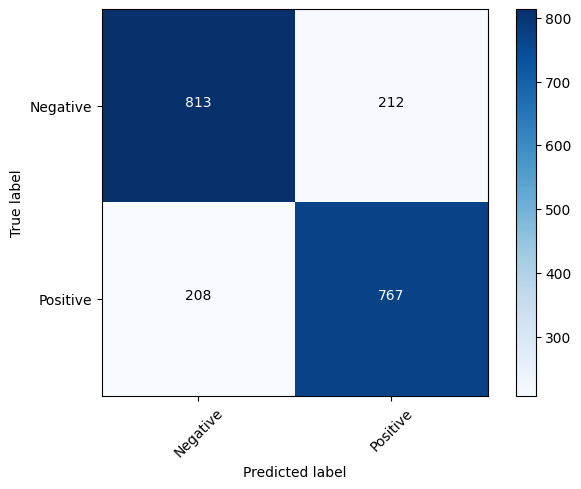


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1025
           1       0.78      0.79      0.79       975

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000

Best Accuracy for Word2Vec: 0.7900


In [ ]:
test_neural_networks(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, "Word2Vec")

Deep Learning is not giving better results than Machine Learning given the small size of the data and architecture